In [1]:
#Technical Analysis Systems (Apostolos Dasilas)
#Taouktsis Xenofon (dai19312)
#Υπολογισμοί Filter(Bollinger)
#Δεδομένα από το [investing.com]
#Τα δεδομένα (.csv) όπως τα κατεβάζουμε απευθείας από το investing.com
#Το αρχείο θα έχει όνομα συμβόλου και μετατροπή από π.χ. ETH.csv σε ETH_md.csv
#UPDATE 171220 - v2

**Εισαγωγή Functions**

In [2]:
#Βήμα 1 | Libraries Input
from google.colab import files
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import matplotlib.dates as mdates
import matplotlib.ticker as ticker

#Global
#pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [3]:
#Βήμα 2 | Upload Dataset Function
def upload_dataset():
    data_upload = files.upload()
    filename = list(data_upload.keys())[0]
    filename = re.sub(".csv", "", filename)
    return filename

In [4]:
#Βήμα 3 | Simple SMA with Plot Function
def sma_info(dataset, window_value, plot_values):
  tmp_sma = pd.DataFrame()
  tmp_sma['Price'] = dataset['Price'].rolling(window=window_value).mean()
  tmp_sma.columns = ['Price'+'_SMA'+ str(window_value)]
  if plot_values == True:
      plt.plot(tmp_sma)
      plt.plot(dataset['Price'])
      plt.show()
  return tmp_sma

In [5]:
#Βήμα 4 | Filter(Bollinger) calculation Formula
def filterBollinger_calculation(dataset,window_value):
    plot_values = False
    drop_columns = ['Open', 'High', 'Low', 'Volume']
    dset = dataset.drop(columns = drop_columns)
    SMA_value = sma_info(dataset,window_value,plot_values)
    sd_sma_value =  pd.DataFrame(dataset['Price'].rolling(window=window_value).std())
    SMA_p_a = SMA_value + (2 * sd_sma_value.values)
    SMA_p_b = SMA_value - (2 * sd_sma_value.values)
    result_values = pd.DataFrame()
    result_values = pd.concat([dset, SMA_value, SMA_p_a, SMA_p_b, sd_sma_value], axis=1)
    result_values.columns = ['Date', 'Price', 'Price_SMA'+str(window_value), 'Price_SMA'+str(window_value)+'+2sd', 'Price_SMA'+str(window_value)+'-2sd', 'sd_SMA'+str(window_value)]
    return result_values

In [6]:
#Βήμα 5 | Plot Filter(Bollinger)
def fb_plot_total_signals(metric_results):
    #import datetime
    #plt.style.use('default')
    #plt.style.use('fivethirtyeight')

    symbol_name = re.sub("_md", "", filename)
    fig1, ax1 = plt.subplots(figsize=(17, 8))
    sma_a_name = metric_results.columns[2]
    sma_a_label = re.sub("Price_", "", sma_a_name)
    sma_b_name = metric_results.columns[3]
    sma_b_label = re.sub("Price_", "", sma_b_name)
    sma_c_name = metric_results.columns[4]
    sma_c_label = re.sub("Price_", "", sma_c_name)
    metric_results = metric_results.set_index(pd.DatetimeIndex(metric_results['Date'].values))
    plt.plot(metric_results['Price'], label = symbol_name, alpha = 0.80, color = 'black')
    plt.plot(metric_results[sma_a_name], label = sma_a_label, alpha = 0.80,  color = 'red')
    plt.plot(metric_results[sma_b_name], label = sma_b_label, alpha = 0.80,  color = 'blue')
    plt.plot(metric_results[sma_c_name], label = sma_c_label, alpha = 0.80,  color = 'blue')

    plt.title('Filter(Bollinger) | Symbol: ' + symbol_name + ' [Price History]')
    plt.ylabel('Price USD')
    plt.legend(loc=2, prop={'size': 7})
    #ax1.set_xlim([total_dates_report.index[0], total_dates_report.index[len(total_dates_report)-1]])
    plt.tight_layout()
    plt.show()
    return

**Απευθείας CSV to CSV_md - INVESTING.COM**

In [7]:
#Βήμα SOS
#Direct CSV to CSV_md (investing.com)
def md_csv_dataset(filename):
    chart = pd.read_csv(filename+".csv",
                        sep = ',')
    n_col = len(chart.columns)
    chart = chart.drop(chart.columns[n_col-1],axis=1)

    if len(chart.columns) < 6 :
        chart['Volume'] = 0
        id = 1
    else :
        id = 0

    chart.columns = ['Date','Price',
                    'Open','High',
                    'Low','Volume']

    #Μορφή Ημερομηνίας
    chart.Date = pd.to_datetime(chart.Date).dt.strftime('%m-%d-%Y')

    chart = chart.replace(',','', regex=True)
    chart = chart.replace('%','', regex=True)
    chart.iloc[:,1:6] = chart.iloc[:,1:6].replace('-','0', regex=True)

    chart['Date'] = chart['Date'].astype(np.datetime64)
    chart['Date'] = chart['Date'].dt.date
    chart['Price'] = chart['Price'].astype(np.float64)
    chart['Open'] = chart['Open'].astype(np.float64)
    chart['High'] = chart['High'].astype(np.float64)
    chart['Low'] = chart['Low'].astype(np.float64)

    if id!=1:
        for i in range(len(chart)):
            tmp_value = chart.iloc[i,5]
            if tmp_value != re.sub("K", "",tmp_value):
                chart.iloc[i,5] = np.float64(re.sub("K", "",tmp_value)) * 1000
            elif tmp_value != re.sub("M", "",tmp_value):
                chart.iloc[i,5] = np.float64(re.sub("M", "",tmp_value)) * 1000000
            elif  tmp_value != re.sub("B", "",tmp_value):
                chart.iloc[i,5] = np.float64(re.sub("B", "",tmp_value)) * 1000000000
        chart['Volume'] = chart['Volume'].astype(np.float64)
    else:
        #update 111220
        chart['Volume'] = 0 #Υπήρχε θέμα με το volume οπότε το θέτω με μηδέν ( 0 ) όταν δεν υπάρχει η στήλη από το investing.com
        #md_col = len(chart.columns)
        #chart = chart.drop(chart.columns[md_col-1],axis=1)

    chart.sort_values(by=['Date'], inplace=True, ascending=True)

    #update 081220
    chart.index = range(len(chart['Date']))

    return chart

**Αρχή Διαδικασιών Filter Bollinger**

In [8]:
#Βήμα 1 | Upload .csv Dataset (.csv)
filename = upload_dataset()
filename
#Το αποτέλεσμα θα είναι π.χ. filename = "AAPL"

Saving INTC Ιστορικά Δεδομένα(2).csv to INTC Ιστορικά Δεδομένα(2).csv


'INTC Ιστορικά Δεδομένα(2)'

In [9]:
#Βήμα 2 | Creation of Dataset (load .csv file)
#Επιλογές Υποδιαστολής
#American xlsx επιλογή decimal_select = '.' εάν το csv έχει αποθηκευτεί με ( . )
#European xlsx επιλογή decimal_select = ',' εάν το csv έχει αποθηκευτεί με ( , )

#Επιλογή Διαχωρισμού Στηλών
#European xlsx sep_select = ';' εάν το csv έχει αποθηκευτεί με ( ; )
#American xlsx sep_select = ',' εάν το csv έχει αποθηκευτεί με ( , )

#decimal_select = ',' #Υποδιαστολή
#sep_select = ';' #Διαχωρισμός Στηλών

dataset = md_csv_dataset(filename)
dataset

<ipython-input-7-052c46b199ca>:20: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  chart.Date = pd.to_datetime(chart.Date).dt.strftime('%m-%d-%Y')


Date   Price    Open    High     Low        Volume
0    2022-01-11  2830.0  2880.0  2885.0  2789.0  4.442000e+09
1    2022-01-12  2983.0  3024.0  3048.0  2952.0  3.890000e+09
2    2022-02-11  2742.0  2827.0  2885.0  2741.0  5.196000e+09
3    2022-02-12  2941.0  2917.0  2943.0  2871.0  3.155000e+09
4    2022-03-11  2739.0  2745.0  2788.0  2717.0  3.968000e+09
..          ...     ...     ...     ...     ...           ...
248  2023-12-05  2895.0  2902.0  2910.0  2872.0  2.415000e+09
249  2023-12-06  3307.0  3140.0  3330.0  3136.0  5.967000e+09
250  2023-12-07  3398.0  3369.0  3408.0  3306.0  3.728000e+09
251  2023-12-09  3886.0  3865.0  4007.0  3865.0  5.465000e+09
252  2023-12-10  3684.0  3680.0  3722.0  3639.0  2.356000e+09

[253 rows x 6 columns]

In [10]:
#Βήμα 3 | Filter Bollinger Results Analysis
window_value = 20
filterBollinger_calculation_results = filterBollinger_calculation(dataset,window_value)
filterBollinger_calculation_results

Date   Price  Price_SMA20  Price_SMA20+2sd  Price_SMA20-2sd  \
0    2022-01-11  2830.0          NaN              NaN              NaN   
1    2022-01-12  2983.0          NaN              NaN              NaN   
2    2022-02-11  2742.0          NaN              NaN              NaN   
3    2022-02-12  2941.0          NaN              NaN              NaN   
4    2022-03-11  2739.0          NaN              NaN              NaN   
..          ...     ...          ...              ...              ...   
248  2023-12-05  2895.0      3361.10      3948.175858      2774.024142   
249  2023-12-06  3307.0      3363.85      3949.287048      2778.412952   
250  2023-12-07  3398.0      3383.90      3943.325608      2824.474392   
251  2023-12-09  3886.0      3414.50      4014.121811      2814.878189   
252  2023-12-10  3684.0      3425.30      4036.645402      2813.954598   

       sd_SMA20  
0           NaN  
1           NaN  
2           NaN  
3           NaN  
4           NaN  
..          ...  
248  293.537929  
249  292.718524  
250  279.712804  
251  299.810905  
252  305.672701  

[253 rows x 6 columns]

In [11]:
#Βήμα 4 | First 25 results
filterBollinger_calculation_results.head(n=25)

Date   Price  Price_SMA20  Price_SMA20+2sd  Price_SMA20-2sd  \
0   2022-01-11  2830.0          NaN              NaN              NaN   
1   2022-01-12  2983.0          NaN              NaN              NaN   
2   2022-02-11  2742.0          NaN              NaN              NaN   
3   2022-02-12  2941.0          NaN              NaN              NaN   
4   2022-03-11  2739.0          NaN              NaN              NaN   
5   2022-04-11  2820.0          NaN              NaN              NaN   
6   2022-05-12  2917.0          NaN              NaN              NaN   
7   2022-06-12  2860.0          NaN              NaN              NaN   
8   2022-07-11  2841.0          NaN              NaN              NaN   
9   2022-07-12  2833.0          NaN              NaN              NaN   
10  2022-08-11  2848.0          NaN              NaN              NaN   
11  2022-08-12  2844.0          NaN              NaN              NaN   
12  2022-09-11  2752.0          NaN              NaN              NaN   
13  2022-09-12  2824.0          NaN              NaN              NaN   
14  2022-10-11  2976.0          NaN              NaN              NaN   
15  2022-10-18  2587.0          NaN              NaN              NaN   
16  2022-10-19  2600.0          NaN              NaN              NaN   
17  2022-10-20  2608.0          NaN              NaN              NaN   
18  2022-10-21  2697.0          NaN              NaN              NaN   
19  2022-10-24  2718.0      2798.00      3031.687150      2564.312850   
20  2022-10-25  2741.0      2793.55      3028.059544      2559.040456   
21  2022-10-26  2721.0      2780.45      2999.137448      2561.762552   
22  2022-10-27  2627.0      2774.70      3003.459676      2545.940324   
23  2022-10-28  2907.0      2773.00      2997.012218      2548.987782   
24  2022-10-31  2843.0      2778.20      3003.712376      2552.687624   

      sd_SMA20  
0          NaN  
1          NaN  
2          NaN  
3          NaN  
4          NaN  
5          NaN  
6          NaN  
7          NaN  
8          NaN  
9          NaN  
10         NaN  
11         NaN  
12         NaN  
13         NaN  
14         NaN  
15         NaN  
16         NaN  
17         NaN  
18         NaN  
19  116.843575  
20  117.254772  
21  109.343724  
22  114.379838  
23  112.006109  
24  112.756188

In [12]:
#Βήμα 5 | Last 25 results
filterBollinger_calculation_results.tail(n=25)

Date   Price  Price_SMA20  Price_SMA20+2sd  Price_SMA20-2sd  \
228  2023-10-03  2722.0      3414.05      4090.058245      2738.041755   
229  2023-10-04  3252.0      3426.15      4080.007308      2772.292692   
230  2023-10-05  2997.0      3419.30      4088.729325      2749.870675   
231  2023-10-07  3274.0      3411.60      4084.143452      2739.056548   
232  2023-10-08  3468.0      3404.70      4071.654145      2737.745855   
233  2023-10-10  3643.0      3393.30      4033.971391      2752.628609   
234  2023-10-13  3597.0      3379.80      3989.051689      2770.548311   
235  2023-10-16  3656.0      3373.20      3966.483317      2779.916683   
236  2023-10-17  3606.0      3363.55      3933.491262      2793.608738   
237  2023-10-18  3564.0      3360.05      3923.824675      2796.275325   
238  2023-10-19  3567.0      3364.95      3934.386832      2795.513168   
239  2023-11-01  2985.0      3340.95      3932.657422      2749.242578   
240  2023-11-04  3235.0      3331.80      3924.150039      2739.449961   
241  2023-11-05  2886.0      3304.65      3927.245679      2682.054321   
242  2023-11-07  3330.0      3302.00      3923.641968      2680.358032   
243  2023-11-08  3489.0      3303.40      3926.673666      2680.126334   
244  2023-11-09  3859.0      3320.45      3985.685526      2655.214474   
245  2023-11-10  3688.0      3327.10      4004.751020      2649.448980   
246  2023-12-01  3029.0      3331.35      3999.889421      2662.810579   
247  2023-12-04  3202.0      3352.45      3972.607696      2732.292304   
248  2023-12-05  2895.0      3361.10      3948.175858      2774.024142   
249  2023-12-06  3307.0      3363.85      3949.287048      2778.412952   
250  2023-12-07  3398.0      3383.90      3943.325608      2824.474392   
251  2023-12-09  3886.0      3414.50      4014.121811      2814.878189   
252  2023-12-10  3684.0      3425.30      4036.645402      2813.954598   

       sd_SMA20  
228  338.004123  
229  326.928654  
230  334.714662  
231  336.271726  
232  333.477073  
233  320.335696  
234  304.625845  
235  296.641659  
236  284.970631  
237  281.887338  
238  284.718416  
239  295.853711  
240  296.175019  
241  311.297839  
242  310.820984  
243  311.636833  
244  332.617763  
245  338.825510  
246  334.269711  
247  310.078848  
248  293.537929  
249  292.718524  
250  279.712804  
251  299.810905  
252  305.672701

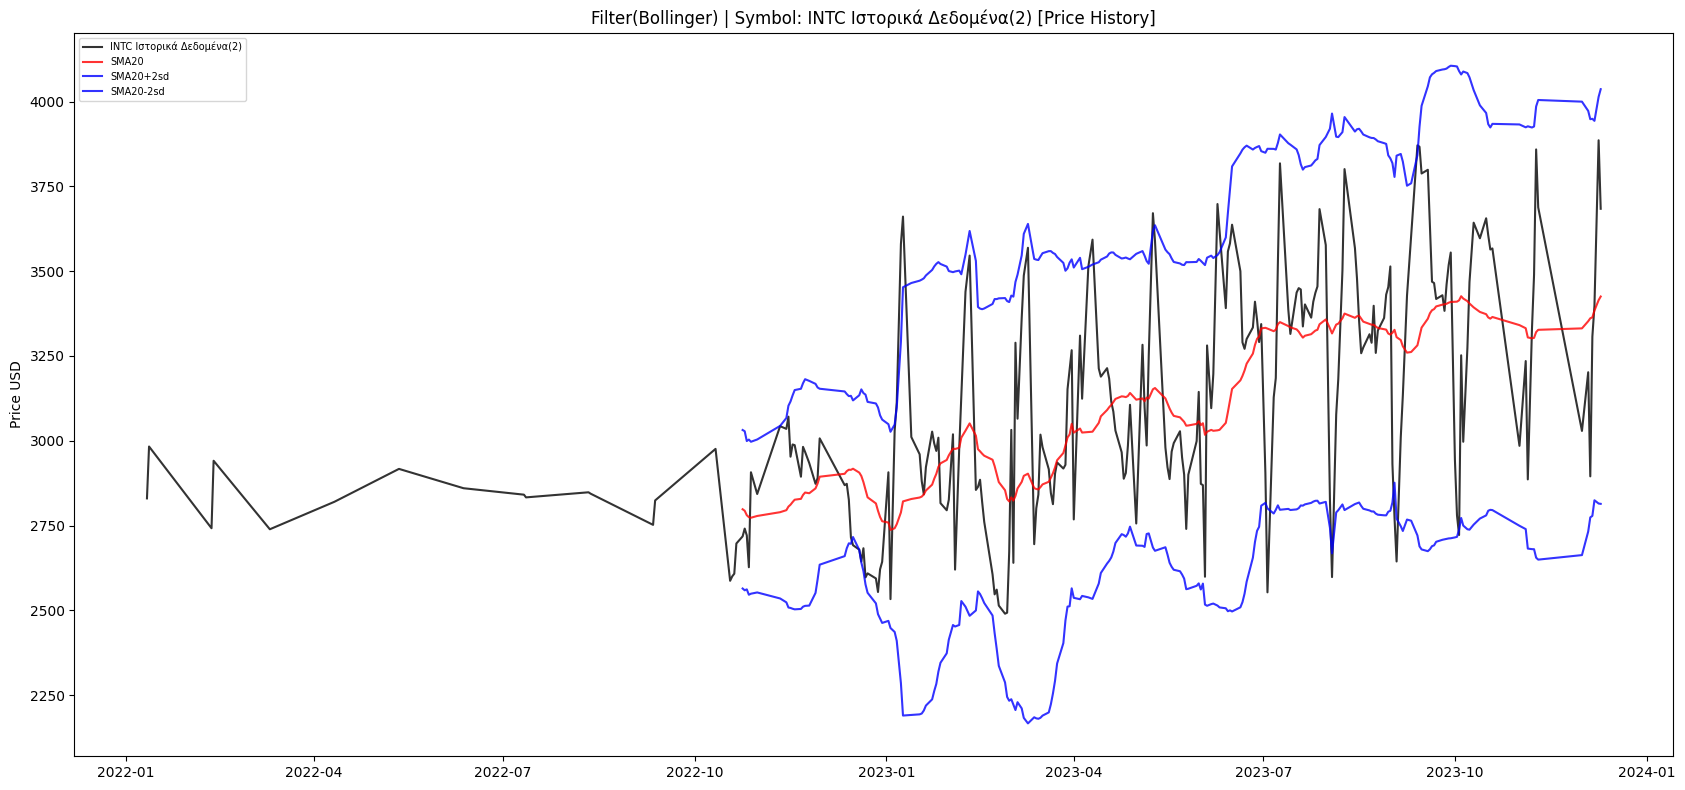

In [13]:
#Βήμα 6 | Filter Bollinger Plot Analysis
fb_plot_total_signals(filterBollinger_calculation_results)